# Sentiment Analysis Model Deployment

## Step 1: Data Preparation

### Load and Explore the Data

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths to dataset
train_dir = "./aclImdb/train"
test_dir = "./aclImdb/test"

def load_data(directory):
    data = {"review": [], "sentiment": []}
    for label in ["pos", "neg"]:
        sentiment = 1 if label == "pos" else 0
        path = os.path.join(directory, label)
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
                data["review"].append(file.read())
                data["sentiment"].append(sentiment)
    return pd.DataFrame(data)

# Load train and test data
train_data = load_data(train_dir)
test_data = load_data(test_dir)

# Combine for preprocessing
data = pd.concat([train_data, test_data], ignore_index=True)


In [3]:
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (50000, 2)


,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [2]:
data.tail()

,review,sentiment
49995,I occasionally let my kids watch this garbage ...,0
49996,When all we have anymore is pretty much realit...,0
49997,The basic genre is a thriller intercut with an...,0
49998,Four things intrigued me as to this film - fir...,0
49999,David Bryce's comments nearby are exceptionall...,0


### Exploratory Data Analysis

Class distribution:
sentiment
1    25000
0    25000
Name: count, dtype: int64


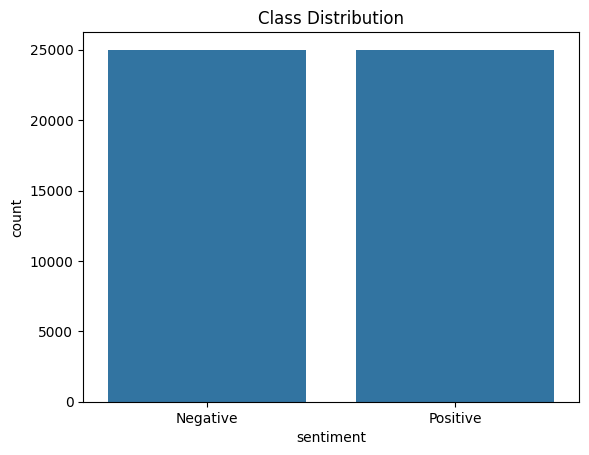

In [4]:
# Check class distribution
print("Class distribution:")
print(data['sentiment'].value_counts())

# Plot class distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=data, x='sentiment')
plt.xticks([0, 1], labels=['Negative', 'Positive'])
plt.title("Class Distribution")
plt.show()


### Text Preprocessing

Clean the text for analysis and modeling:

In [10]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords 
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Preprocessing function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
data["cleaned_review"] = data["review"].apply(preprocess_text)
data.drop(columns=["review"], inplace=True)
data.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atefi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atefi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,sentiment,cleaned_review
0,1,bromwell high cartoon comedy ran time programs...
1,1,homelessness houselessness george carlin state...
2,1,brilliant overacting lesley ann warren best dr...
3,1,easily underrated film inn brooks cannon sure ...
4,1,typical mel brooks film much less slapstick mo...


## Save Preprocessed Data
Save the cleaned dataset to a CSV file:

In [15]:
data.to_csv("preprocessed_imdb.csv", index=False)
print("Preprocessed data saved to 'preprocessed_imdb.csv'")


Preprocessed data saved to 'preprocessed_imdb.csv'


In [2]:
import pandas as pd
# Load the preprocessed data
data = pd.read_csv("preprocessed_imdb.csv")

# Display the first few rows to verify
print(data.head())


   sentiment                                     cleaned_review
0          1  bromwell high cartoon comedy ran time programs...
1          1  homelessness houselessness george carlin state...
2          1  brilliant overacting lesley ann warren best dr...
3          1  easily underrated film inn brooks cannon sure ...
4          1  typical mel brooks film much less slapstick mo...


##  Split Dataset
Split the dataset into training and validation sets:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data["cleaned_review"], data["sentiment"], test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_val)}")


Training set size: 40000
Testing set size: 10000


### TF-IDF Feature Extraction

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for simplicity

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation data
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"TF-IDF feature matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF feature matrix shape (validation): {X_val_tfidf.shape}")


TF-IDF feature matrix shape (train): (40000, 5000)
TF-IDF feature matrix shape (validation): (10000, 5000)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle


with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

### Train a Baseline Model "Logistic Regression".


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = log_reg.predict(X_val_tfidf)

# Evaluate the model
print("Classification Report:\n")
print(classification_report(y_val, y_pred))

# Overall accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4945
           1       0.89      0.90      0.89      5055

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 0.89


In [13]:
import joblib




with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(log_reg, model_file)
print("Model saved successfully!")


Model saved successfully!


In [14]:
with open('logistic_regression_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

print("Model loaded successfully!")


Model loaded successfully!


In [16]:
# Example: Predict the sentiment of a new sample
new_sample = ["This movie was very good!"]
new_sample_tfidf = tfidf_vectorizer.transform(new_sample)  # Transform input using the same vectorizer
prediction = model.predict(new_sample_tfidf)

# Display prediction
print("Prediction:", "Positive" if prediction[0] == 1 else "Negative")


Prediction: Positive


#  Data Preparation for DL

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # Limit to top 5000 words
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=200, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=200, padding='post', truncating='post')

print(f"Padded training data shape: {X_train_padded.shape}")
print(f"Padded validation data shape: {X_val_padded.shape}")


Padded training data shape: (40000, 200)
Padded validation data shape: (10000, 200)


### Build the CNN Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),  # Embedding layer
    Conv1D(filters=128, kernel_size=5, activation='relu'),  # Convolution layer
    MaxPooling1D(pool_size=4),  # Max pooling layer
    Conv1D(filters=128, kernel_size=5, activation='relu'),  # Another Convolution layer
    MaxPooling1D(pool_size=4),  # Max pooling layer
    Flatten(),  # Flatten the output of the convolutional layers
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 11, 128)          

### Train the Model

In [23]:
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=5, 
    batch_size=32,
    verbose=1
)


Epoch 1/5
1250/1250 [==============================] - 20s 11ms/step - loss: 0.3635 - accuracy: 0.8312 - val_loss: 0.2993 - val_accuracy: 0.8788
Epoch 2/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.2436 - accuracy: 0.9047 - val_loss: 0.2837 - val_accuracy: 0.8811
Epoch 3/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.1750 - accuracy: 0.9353 - val_loss: 0.3148 - val_accuracy: 0.8769
Epoch 4/5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.1075 - accuracy: 0.9651 - val_loss: 0.3848 - val_accuracy: 0.8588
Epoch 5/5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.0668 - accuracy: 0.9801 - val_loss: 0.4506 - val_accuracy: 0.8666


### Evaluate the Model

In [24]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val_padded, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.2f}")

# Predict and analyze
y_pred = (model.predict(X_val_padded) > 0.5).astype("int32")

from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_val, y_pred))


Validation Accuracy: 0.87
313/313 [==============================] - 2s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      4945
           1       0.87      0.86      0.87      5055

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



##  Save the Trained Model

In [25]:
# Save the trained model to a file
model.save('sentiment_model.h5')  # You can save as .h5 or in TensorFlow's SavedModel format


: 